In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Reshape
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Lambda, Activation
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

In [2]:
def conv_bn_pool(
    inp_tensor,
    layer_idx,
    conv_filters,
    conv_kernel_size,
    conv_strides,
    conv_pad,
    pool = '',
    pool_size = (2, 2),
    pool_strides = None,
    conv_layer_prefix = 'conv',
):
    x = ZeroPadding2D(padding = conv_pad, name = 'pad{}'.format(layer_idx))(
        inp_tensor
    )
    x = Conv2D(
        filters = conv_filters,
        kernel_size = conv_kernel_size,
        strides = conv_strides,
        padding = 'valid',
        name = '{}{}'.format(conv_layer_prefix, layer_idx),
    )(x)
    x = BatchNormalization(
        epsilon = 1e-5, momentum = 1.0, name = 'bn{}'.format(layer_idx)
    )(x)
    x = Activation('relu', name = 'relu{}'.format(layer_idx))(x)
    if pool == 'max':
        x = MaxPooling2D(
            pool_size = pool_size,
            strides = pool_strides,
            name = 'mpool{}'.format(layer_idx),
        )(x)
    elif pool == 'avg':
        x = AveragePooling2D(
            pool_size = pool_size,
            strides = pool_strides,
            name = 'apool{}'.format(layer_idx),
        )(x)
    return x


# Block of layers: Conv --> BatchNorm --> ReLU --> Dynamic average pool (fc6 -> apool6 only)
def conv_bn_dynamic_apool(
    inp_tensor,
    layer_idx,
    conv_filters,
    conv_kernel_size,
    conv_strides,
    conv_pad,
    conv_layer_prefix = 'conv',
):
    x = ZeroPadding2D(padding = conv_pad, name = 'pad{}'.format(layer_idx))(
        inp_tensor
    )
    x = Conv2D(
        filters = conv_filters,
        kernel_size = conv_kernel_size,
        strides = conv_strides,
        padding = 'valid',
        name = '{}{}'.format(conv_layer_prefix, layer_idx),
    )(x)
    x = BatchNormalization(
        epsilon = 1e-5, momentum = 1.0, name = 'bn{}'.format(layer_idx)
    )(x)
    x = Activation('relu', name = 'relu{}'.format(layer_idx))(x)
    x = GlobalAveragePooling2D(name = 'gapool{}'.format(layer_idx))(x)
    x = Reshape((1, 1, conv_filters), name = 'reshape{}'.format(layer_idx))(x)
    return x

In [3]:
class Resnet1D(Model):
    def __init__(self, params=None, is_training=False):
        super(Resnet1D, self).__init__()
    
    def call(self, inputs, training=None, mask=None):
        inp = inputs['features_input']
        x = conv_bn_pool(
            inp,
            layer_idx = 1,
            conv_filters = 96,
            conv_kernel_size = (7, 7),
            conv_strides = (2, 2),
            conv_pad = (1, 1),
            pool = 'max',
            pool_size = (3, 3),
            pool_strides = (2, 2),
        )
        x = conv_bn_pool(
            x,
            layer_idx = 2,
            conv_filters = 256,
            conv_kernel_size = (5, 5),
            conv_strides = (2, 2),
            conv_pad = (1, 1),
            pool = 'max',
            pool_size = (3, 3),
            pool_strides = (2, 2),
        )
        x = conv_bn_pool(
            x,
            layer_idx = 3,
            conv_filters = 384,
            conv_kernel_size = (3, 3),
            conv_strides = (1, 1),
            conv_pad = (1, 1),
        )
        x = conv_bn_pool(
            x,
            layer_idx = 4,
            conv_filters = 256,
            conv_kernel_size = (3, 3),
            conv_strides = (1, 1),
            conv_pad = (1, 1),
        )
        x = conv_bn_pool(
            x,
            layer_idx = 5,
            conv_filters = 256,
            conv_kernel_size = (3, 3),
            conv_strides = (1, 1),
            conv_pad = (1, 1),
            pool = 'max',
            pool_size = (5, 3),
            pool_strides = (3, 2),
        )
        x = conv_bn_dynamic_apool(
            x,
            layer_idx = 6,
            conv_filters = 4096,
            conv_kernel_size = (9, 1),
            conv_strides = (1, 1),
            conv_pad = (0, 0),
            conv_layer_prefix = 'fc',
        )
        x = conv_bn_pool(
            x,
            layer_idx = 7,
            conv_filters = 1024,
            conv_kernel_size = (1, 1),
            conv_strides = (1, 1),
            conv_pad = (0, 0),
            conv_layer_prefix = 'fc',
        )
        x = Lambda(lambda y: K.l2_normalize(y, axis = 3), name = 'norm')(x)
        x = Conv2D(
            filters = 1024,
            kernel_size = (1, 1),
            strides = (1, 1),
            padding = 'valid',
            name = 'fc8',
        )(x)
        return x
    
class Model:
    def __init__(self, is_training = False):
        self.X = tf.placeholder(tf.float32, [None, 512, None, 1])
        self.model = Resnet1D(is_training = is_training)
        inputs = {'features_input': self.X}
        self.logits = self.model.call(inputs)

In [4]:
ckpt_path = 'out/vggvox.ckpt'

In [5]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model()
sess.run(tf.global_variables_initializer())
var_lists = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
saver = tf.train.Saver(var_list = var_lists)
saver.restore(sess, ckpt_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Restoring parameters from out/vggvox.ckpt


In [6]:
# Signal processing
SAMPLE_RATE = 16000
PREEMPHASIS_ALPHA = 0.97
FRAME_LEN = 0.025
FRAME_STEP = 0.01
NUM_FFT = 512
BUCKET_STEP = 1
MAX_SEC = 10

# Model
WEIGHTS_FILE = "data/model/weights.h5"
COST_METRIC = "cosine"  # euclidean or cosine
INPUT_SHAPE=(NUM_FFT,None,1)

# IO
ENROLL_LIST_FILE = "cfg/enroll_list.csv"
TEST_LIST_FILE = "cfg/test_list.csv"
RESULT_FILE = "res/results.csv"

In [7]:
import librosa
import numpy as np
from scipy.signal import lfilter, butter

import sigproc


def load_wav(filename, sample_rate):
    audio, sr = librosa.load(filename, sr = sample_rate, mono = True)
    audio = audio.flatten()
    return audio


def normalize_frames(m, epsilon = 1e-12):
    return np.array([(v - np.mean(v)) / max(np.std(v), epsilon) for v in m])


# https://github.com/christianvazquez7/ivector/blob/master/MSRIT/rm_dc_n_dither.m
def remove_dc_and_dither(sin, sample_rate):
    if sample_rate == 16e3:
        alpha = 0.99
    elif sample_rate == 8e3:
        alpha = 0.999
    else:
        print('Sample rate must be 16kHz or 8kHz only')
        exit(1)
    sin = lfilter([1, -1], [1, -alpha], sin)
    dither = (
        np.random.random_sample(len(sin))
        + np.random.random_sample(len(sin))
        - 1
    )
    spow = np.std(dither)
    sout = sin + 1e-6 * spow * dither
    return sout


def get_fft_spectrum(filename, buckets = None):
    signal = load_wav(filename, SAMPLE_RATE)
    signal *= 2 ** 15

    # get FFT spectrum
    signal = remove_dc_and_dither(signal, SAMPLE_RATE)
    signal = sigproc.preemphasis(signal, coeff = PREEMPHASIS_ALPHA)
    frames = sigproc.framesig(
        signal,
        frame_len = FRAME_LEN * SAMPLE_RATE,
        frame_step = FRAME_STEP * SAMPLE_RATE,
        winfunc = np.hamming,
    )
    fft = abs(np.fft.fft(frames, n = NUM_FFT))
    fft_norm = normalize_frames(fft.T)
    
    if buckets:

        # truncate to max bucket sizes
        rsize = max(k for k in buckets if k <= fft_norm.shape[1])
        rstart = int((fft_norm.shape[1] - rsize) / 2)
        out = fft_norm[:, rstart : rstart + rsize]
        return out
    
    else:
        return fft_norm

In [8]:
def build_buckets(max_sec, step_sec, frame_step):
    buckets = {}
    frames_per_sec = int(1 / frame_step)
    end_frame = int(max_sec * frames_per_sec)
    step_frame = int(step_sec * frames_per_sec)
    for i in range(0, end_frame + 1, step_frame):
        s = i
        s = np.floor((s - 7 + 2) / 2) + 1  # conv1
        s = np.floor((s - 3) / 2) + 1  # mpool1
        s = np.floor((s - 5 + 2) / 2) + 1  # conv2
        s = np.floor((s - 3) / 2) + 1  # mpool2
        s = np.floor((s - 3 + 2) / 1) + 1  # conv3
        s = np.floor((s - 3 + 2) / 1) + 1  # conv4
        s = np.floor((s - 3 + 2) / 1) + 1  # conv5
        s = np.floor((s - 3) / 2) + 1  # mpool5
        s = np.floor((s - 1) / 1) + 1  # fc6
        if s > 0:
            buckets[i] = int(s)
    return buckets

buckets = build_buckets(MAX_SEC, BUCKET_STEP, FRAME_STEP)
buckets

{100: 2,
 200: 5,
 300: 8,
 400: 11,
 500: 14,
 600: 17,
 700: 20,
 800: 23,
 900: 27,
 1000: 30}

In [ ]:
import IPython.display as ipd
ipd.Audio('data/wav/test/19-198-0001.wav')

In [10]:
from glob import glob

files = glob('data/wav/enroll/*.wav')
files

['data/wav/enroll/27-123349-0000.wav',
 'data/wav/enroll/19-227-0000.wav',
 'data/wav/enroll/26-495-0000.wav']

In [ ]:
ipd.Audio(files[2])

In [11]:
x = [get_fft_spectrum(f, buckets)[:, :900] for f in files]
x = np.array(x)

In [12]:
r = sess.run(model.logits, feed_dict = {model.X: np.expand_dims(x, -1)})
r = r[:,0,0,:]
r.shape

(3, 1024)

In [13]:
from scipy.spatial.distance import cdist

In [14]:
cdist(r, r, metric=COST_METRIC)

array([[0.        , 1.11476062, 1.03959024],
       [1.11476062, 0.        , 1.28692918],
       [1.03959024, 1.28692918, 0.        ]])

In [15]:
import matplotlib.pyplot as plt

plt.imshow(x[0])

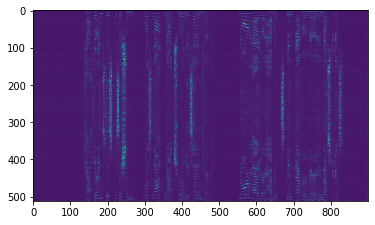

In [16]:
plt.imshow(x[1])